In [54]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [46]:
dfr = pd.read_csv('./data/winequality-red.csv', sep=';')
target = 'quality'

In [47]:
dfr.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [48]:
X = dfr.drop(columns=[target])
y = dfr[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [73]:
def round_results(y_pred):
    #To get the actual qualitys
    y_pred_rounded = np.array([])
    for pred in y_pred:
        y_pred_rounded = np.append(y_pred_rounded, round(pred))

    y_pred_indexed = pd.Series(y_pred_rounded, y_test.index)

    return y_pred_indexed

In [66]:
def basic_pipeline(X_train, y_train):
    model = xgb.XGBRegressor()

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    return round_results(y_pred)

In [78]:
def calculate_scores(y_true, y_pred):
    report = classification_report(
    y_true, y_pred, target_names=['3', '4', '5', '6', '7', '8'], output_dict=True
    )

    df_report = pd.DataFrame(report).transpose()

    df_report = df_report.drop(columns=['support'], errors='ignore')

    plt.figure(figsize=(10, 6))
    sns.heatmap(
        df_report.iloc[:-1, :].astype(float),
        annot=True, cmap="YlGnBu", cbar=True, fmt=".2f", linewidths=0.5,
    )

    plt.title('Figure 8: Classification Report', fontsize=16, weight='bold')
    plt.xlabel('Metrics', fontsize=14)
    plt.ylabel('Classes', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.tight_layout()

    plt.show()


In [79]:
y_pred_rounded = basic_pipeline(X_train, y_train)

416     6.0
749     6.0
1321    6.0
1064    6.0
659     5.0
       ... 
69      5.0
207     5.0
786     5.0
1514    6.0
1049    6.0
Length: 480, dtype: float64


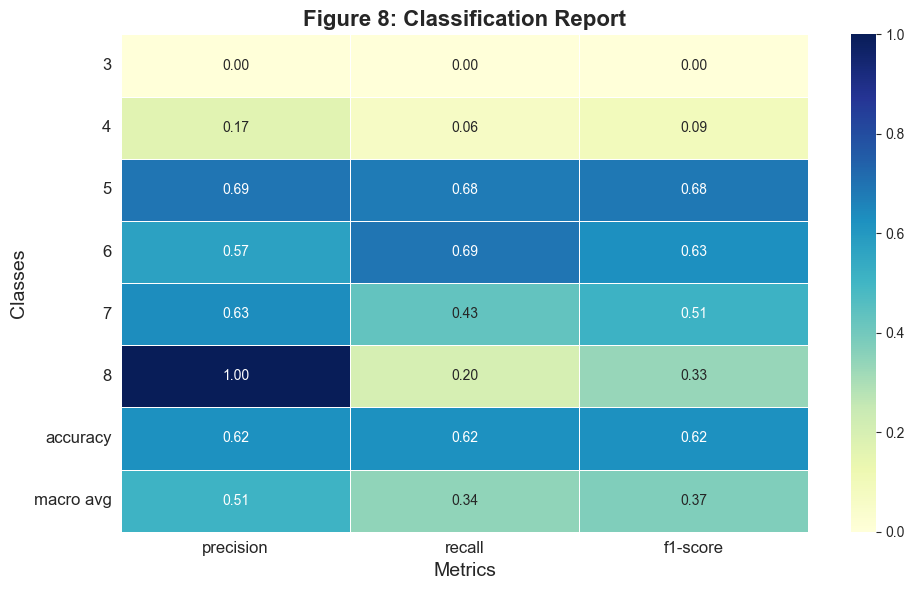

In [80]:
calculate_scores(y_test, y_pred_rounded)

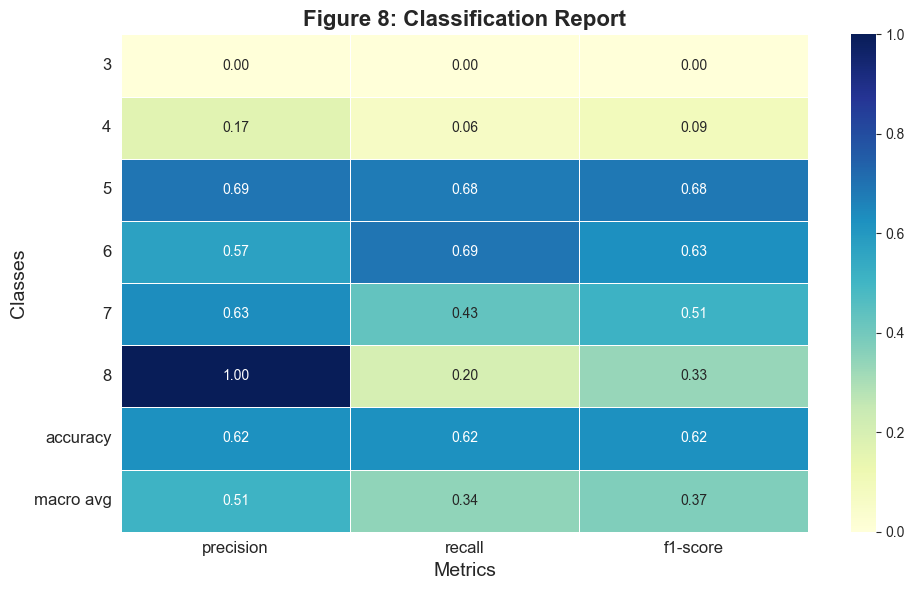

In [82]:
model = xgb.XGBRegressor(enable_categorial = True)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

calculate_scores(y_test, round_results(y_pred))

In [88]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X.columns)
    ]
)

preprocess.fit_transform(X)

pd.DataFrame(preprocess.fit_transform(X), columns=X.columns)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246
1,-0.298547,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,-0.584777
2,-0.298547,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,-0.584777
3,1.654856,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,-0.584777
4,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246
...,...,...,...,...,...,...,...,...,...,...,...
1594,-1.217796,0.403229,-0.980669,-0.382271,0.053845,1.542054,-0.075043,-0.978765,0.899886,-0.461180,0.072294
1595,-1.390155,0.123905,-0.877968,-0.240375,-0.541259,2.211469,0.137820,-0.862162,1.353436,0.601055,0.729364
1596,-1.160343,-0.099554,-0.723916,-0.169427,-0.243707,1.255161,-0.196679,-0.533554,0.705508,0.542042,0.541630
1597,-1.390155,0.654620,-0.775267,-0.382271,-0.264960,1.542054,-0.075043,-0.676657,1.677400,0.305990,-0.209308
